## Movie reviews: Predict Movie Review Class Using Critic Consensus

Researcher: Ryan Brown <br>
Email: rwbrown002@berkeley.edu

In [717]:
from collections import Counter
import json
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from plotly.colors import sequential
import plotly.graph_objs as go
import random
import re
import seaborn as sns
import shap
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, \
                            log_loss, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from transformers import DistilBertTokenizerFast, enable_full_determinism, logging, \
                         pipeline as trans_pipe, TFDistilBertForSequenceClassification, set_seed
import urllib3

seed = 1534
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
set_seed(seed)

# for various reasons (perf, speed, etc), full_determinism is not enabled -- results may vary
# enable_full_determinism(seed)

#### ``Preprocessing``

In [2]:
# load movies
movies = pd.read_csv('../data/raw/rotten_tomatoes_movies.csv')

In [3]:
movies.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'],
      dtype='object')

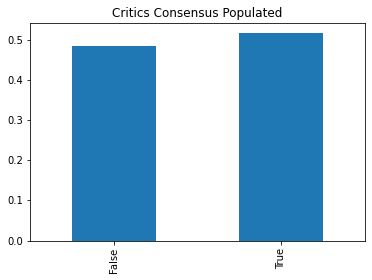

In [4]:
# plot NaN reviews
fig, ax = plt.subplots()
movies['NonNullConsensus'] = (~movies['critics_consensus'].isnull())
movies.NonNullConsensus.value_counts(normalize=True).plot.bar()
ax.set_title('Critics Consensus Populated')
plt.show()

In [5]:
# filter out null consensus
movies = movies.loc[~movies.critics_consensus.isnull(),:]

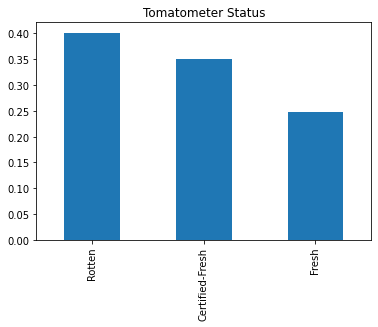

In [6]:
# plot tomatometer_status
fig, ax = plt.subplots()
movies.tomatometer_status.value_counts(normalize=True).plot.bar()
ax.set_title('Tomatometer Status')
plt.show()

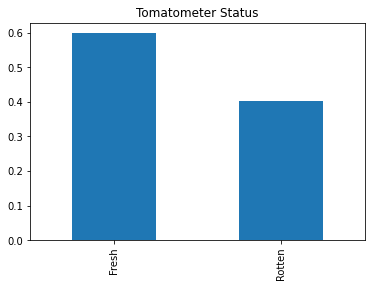

In [7]:
# combine fresh with certified fresh and reevaluate
movies['tomatometer_status'] = movies['tomatometer_status'].apply(lambda x: 'Fresh' if x in ('Certified-Fresh', 'Fresh') \
                                                                  else 'Rotten')
fig, ax = plt.subplots()
movies.tomatometer_status.value_counts(normalize=True).plot.bar()
ax.set_title('Tomatometer Status')
plt.show()

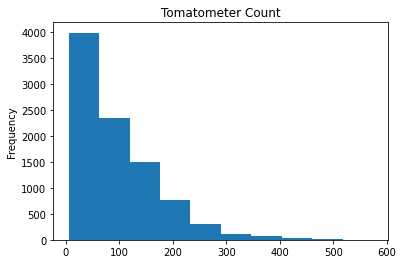

In [8]:
# plot tomatometer_count
fig, ax = plt.subplots()
movies.tomatometer_count.plot.hist()
ax.set_title('Tomatometer Count')
plt.show()

In [9]:
# replace rotten, fresh with 0,1
movies['tomatometer_status'] = movies['tomatometer_status'].apply(lambda x: 1 if x=='Fresh' else 0)

In [10]:
# define X, y
X, y = movies.critics_consensus, movies.tomatometer_status

In [11]:
# split data; 60-20-20

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y, # stratify to equal response %
                                                    random_state=seed,
                                                    shuffle=True)

# train/valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size=0.25,
                                                      stratify=y_train, # stratify to equal response %
                                                      random_state=seed,
                                                      shuffle=True)

print('Train shape %s' % Counter(y_train))
print('Valid shape %s' % Counter(y_valid))
print('Test shape %s' % Counter(y_test))

Train shape Counter({1: 3279, 0: 2201})
Valid shape Counter({1: 1093, 0: 734})
Test shape Counter({1: 1093, 0: 734})


In [12]:
# get class weights on train data
rotten, fresh = np.bincount(y_train)
total = rotten + fresh

# Scaling by total/2 helps keep the loss to a similar magnitude.
weight_for_rotten = (1 / rotten) * (total / 2.0) 
weight_for_fresh = (1 / fresh) * (total / 2.0)

class_weight = {0: weight_for_rotten, 
                1: weight_for_fresh}

print(class_weight)

{0: 1.2448886869604725, 1: 0.8356206160414761}


#### ``Logistic Regression Baseline``

In [467]:
# build pipeline for tokenization, scaling, modeling
pipeline = Pipeline([('vectorize', CountVectorizer(strip_accents='unicode',
                                                   lowercase='true',
                                                   stop_words='english',
                                                   analyzer='word',
                                                   max_features=500 # only retain x number of features
                                                  )),
                     ('scaler', Normalizer(norm='l2', # Normalize samples individually to unit norm
                                           copy=False)),
                     ('lr', LogisticRegression(penalty='elasticnet', # regularization
                                               tol=1e-4,
                                               random_state=seed,
                                               solver='saga',
                                               class_weight=class_weight, # weight using inverse occurences
                                               l1_ratio=0 # l2 regularization
                                              ))
                     ])

# fit model
pipeline.fit(X_train.ravel().astype('U'),
             y_train)

Pipeline(steps=[('vectorize',
                 CountVectorizer(lowercase='true', max_features=500,
                                 stop_words='english',
                                 strip_accents='unicode')),
                ('scaler', Normalizer(copy=False)),
                ('lr',
                 LogisticRegression(class_weight={0: 1.2448886869604725,
                                                  1: 0.8356206160414761},
                                    l1_ratio=0, penalty='elasticnet',
                                    random_state=1534, solver='saga'))])

In [468]:
# predict

# probs
train_probs = pipeline.predict_proba(X_train.ravel().astype('U'))
valid_probs = pipeline.predict_proba(X_valid.ravel().astype('U'))
test_probs = pipeline.predict_proba(X_test.astype('U'))

# preds
train_preds = (train_probs[:,1] >= 0.5).astype(bool)
valid_preds = (valid_probs[:,1] >= 0.5).astype(bool)
test_preds = (test_probs[:,1] >= 0.5).astype(bool)

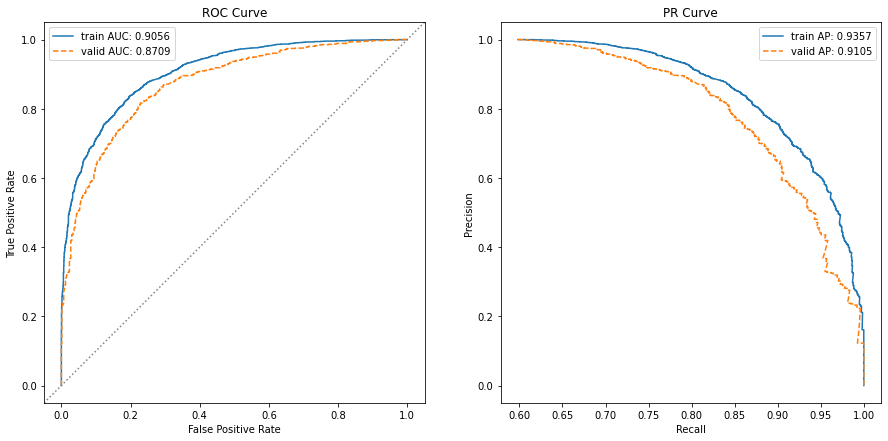

In [469]:
# auc
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

fpr_train, tpr_train, _ = roc_curve(y_train, train_probs[:,1])
fpr_valid, tpr_valid, _ = roc_curve(y_valid, valid_probs[:,1])

# pr
prec_train, recall_train, _ = precision_recall_curve(y_train, train_probs[:,1])
prec_valid, recall_valid, _ = precision_recall_curve(y_valid, valid_probs[:,1])

ax1.plot(fpr_train, tpr_train, label=f'train AUC: {round(roc_auc_score(y_train, train_probs[:,1]),4)}')
ax1.plot(fpr_valid, tpr_valid, label=f'valid AUC: {round(roc_auc_score(y_valid, valid_probs[:,1]),4)}', 
         linestyle='--')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, color='gray', linestyle=':')

ax2.plot(prec_train, recall_train, label=f'train AP: {round(average_precision_score(y_train, train_probs[:,1]),4)}')
ax2.plot(prec_valid, recall_valid, label=f'valid AP: {round(average_precision_score(y_valid, valid_probs[:,1]),4)}', 
         linestyle='--')

ax1.legend(loc=0)
ax2.legend(loc=0)

ax1.set_title('ROC Curve')
ax2.set_title('PR Curve')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

plt.show()

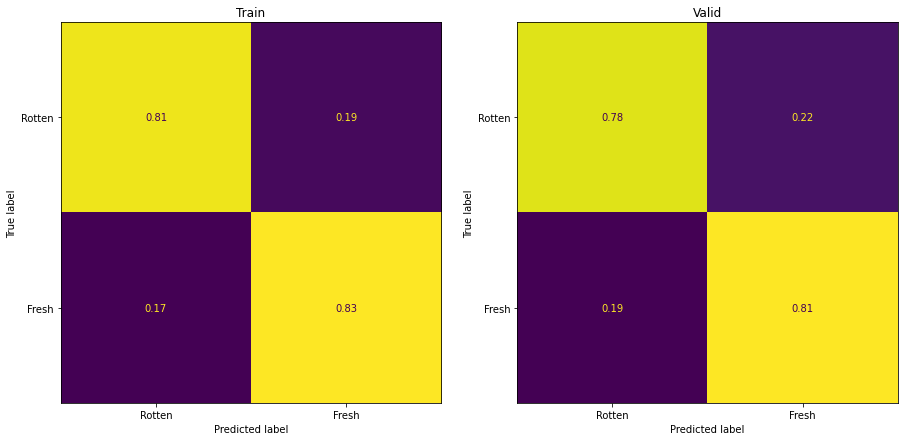

In [470]:
# confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

cm_train = confusion_matrix(y_train, train_preds,
                            normalize='true')

cm_valid = confusion_matrix(y_valid, valid_preds,
                            normalize='true')

ConfusionMatrixDisplay(confusion_matrix=cm_train,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax1, colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=cm_valid,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax2, colorbar=False)

ax1.set_title('Train')
ax2.set_title('Valid')

plt.show()

In [367]:
# pre-make initial df for appending results
model_results = pd.DataFrame(columns=['Run ID', 'Algorithm', 'Description', 
                                      'Train Loss', 'Valid Loss', 
                                      'Train Accuracy', 'Valid Accuracy'])

In [368]:
# accuracy
lr_train_accuracy = round(accuracy_score(train_preds, y_train),4)
lr_valid_accuracy = round(accuracy_score(valid_preds, y_valid),4)

# use categorical cross entropy for better comparison to bert
lr_train_loss = round(tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_train, train_probs).numpy(),4)
lr_valid_loss = round(tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_valid, valid_probs).numpy(),4)

model_results = model_results.append({
    'Run ID': '00', 
    'Algorithm': 'Logistic regression', 
    'Description': 'L2 regularization', 
    'Train Loss': lr_train_loss, 
    'Valid Loss': lr_valid_loss, 
    'Train Accuracy': lr_train_accuracy, 
    'Valid Accuracy': lr_valid_accuracy
}, ignore_index=True)

print('train accuracy: %s' % lr_train_accuracy)
print('validation accuracy: %s' % lr_valid_accuracy)

train accuracy: 0.8197
validation accuracy: 0.7947


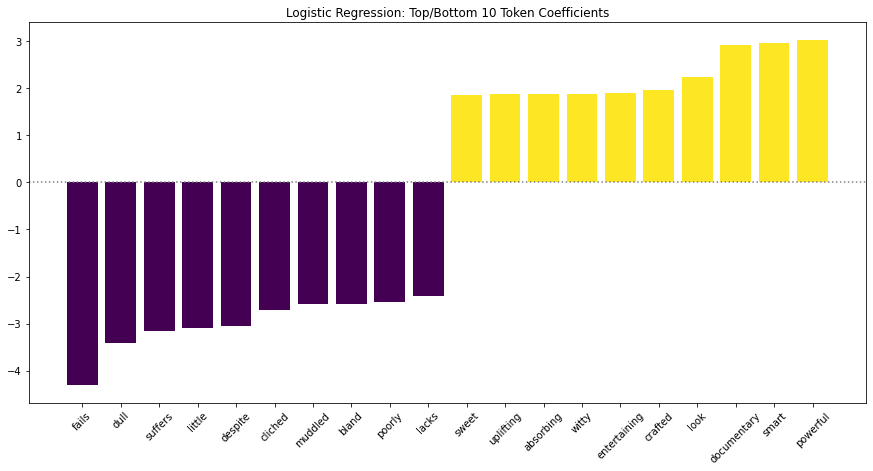

In [515]:
# visualize coeficients for lr

# set plots
fig, ax = plt.subplots(figsize=(15, 7))

# get coefs
lr_coefs = pd.DataFrame(zip(pipeline.named_steps['vectorize'].get_feature_names_out(),
                            pipeline.named_steps['lr'].coef_.ravel()), columns=['names', 'values']) \
             .sort_values('values') \
             .reset_index(drop=True)
# filter to top/bottom 10
plt_frame = lr_coefs.iloc[np.r_[0:10, -10:0]]

# plot
ax.bar(x=plt_frame['names'], height=plt_frame['values'], color=plt.get_cmap('viridis')(plt_frame['values']))

plt.xticks(rotation = 45)
plt.axhline(y=0, color='gray', linestyle=':')
ax.set_title('Logistic Regression: Top/Bottom 10 Token Coefficients')
plt.show()

In [274]:
# save model to pickle
with open('../models/critics_consensus_bert_v7/logistic_reg_pipeline.pkl','wb') as f:
    pickle.dump(pipeline,f)

#### ``BERT``

In [21]:
# disable ssl and hide ssl warnings; enable only if error downloading hugging face (proxy issues/vpn)
urllib3.disable_warnings()
os.environ["CURL_CA_BUNDLE"]=""

# set verbosity to the warning level
logging.set_verbosity_error()

# set model name
model_name = 'distilbert-base-uncased'

In [28]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        # initiate model from download or cache if already downloaded
        model = TFDistilBertForSequenceClassification.from_pretrained(model_name,
                                                                      num_labels=2)
        
        # Tune the learning rate for the optimizer
        # Choose an optimal value from [5e-5, 3e-5, 2e-5]; from original paper
        hp_learning_rate = hp.Choice('learning_rate', values=[5e-5, 3e-5, 2e-5, 1e-5])
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        
        return model

    def fit(self, hp, model, X_train, y_train, X_valid, y_valid, **kwargs):
        # Tune the max length
        # Choose an optimal value from [64, 128, 256, 320, 384, 512]
        hp_max_length = hp.Choice('max_length', values=[64, 128, 256, 320, 384, 512])
        
        # Tune the batch size
        # Choose an optimal value from [240, 120, 64, 32, 16, 14, 12, 6]
        hp_batch_size = hp.Choice('batch_size', values=[240, 120, 64, 32, 16, 14, 12, 6])
        
        # set static params
        truncate=True
        pad=True
        
        # tokenize data
        tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
        
        train_tokens = tokenizer(list(X_train.ravel().astype('U')),
                                 max_length=hp_max_length,
                                 truncation=truncate,
                                 padding=pad)

        valid_tokens = tokenizer(list(X_valid.ravel().astype('U')),
                                 max_length=hp_max_length,
                                 truncation=truncate,
                                 padding=pad)
    
        # convert to tensors
        train_tensor = tf.data.Dataset.from_tensor_slices((dict(train_tokens), y_train))
        valid_tensor = tf.data.Dataset.from_tensor_slices((dict(valid_tokens), y_valid))

        # batch
        train_tensor = train_tensor.batch(hp_batch_size)
        valid_tensor = valid_tensor.batch(hp_batch_size)
        
        return model.fit(
            train_tensor,
            validation_data=valid_tensor,
            batch_size=hp_batch_size,
            class_weight=class_weight,
            **kwargs,
        )

In [29]:
hp = kt.HyperParameters()
hypermodel = MyHyperModel()
tuner = kt.Hyperband(hypermodel,
                     objective='val_accuracy',
                     max_epochs=5,
                     directory=None,
                     project_name='critics_consensus_bert_v7',
                     factor=2)

In [30]:
# stop on val convergence
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=2,
    mode='min',
    restore_best_weights=True)

In [31]:
# run the search
tuner_hist = tuner.search(X_train=X_train, 
                          y_train=y_train, 
                          X_valid=X_valid,
                          y_valid=y_valid,
                          epochs=5,
                          callbacks=[early_stopping],
                          verbose=1)

Trial 21 Complete [00h 45m 02s]
val_accuracy: 0.8894362449645996

Best val_accuracy So Far: 0.9195402264595032
Total elapsed time: 09h 57m 46s
INFO:tensorflow:Oracle triggered exit


In [267]:
# get trial results in df

# create df with columns
hp_df = pd.DataFrame(columns=['trial id', 'max seq. len.', 'batch size', 'learning rate', 
                              'init. epoch', 'epochs', 'train loss', 'valid loss', 
                              'train accuracy', 'valid accuracy']
                    )

# iterate through jsons in directory
for root, dirs, files in os.walk('critics_consensus_bert_v7'):
    for f in files:                        
            if f=='trial.json':                    
                f = os.path.join(root, f)
                with open(f,'r') as f:
                    json_data = f.read()
                trial_dict = json.loads(json_data)
                hp_df = hp_df.append({
                    'trial id': trial_dict['trial_id'],
                    'max seq. len.': trial_dict['hyperparameters']['values']['max_length'],
                    'batch size': trial_dict['hyperparameters']['values']['batch_size'],
                    'learning rate': trial_dict['hyperparameters']['values']['learning_rate'],
                    'init. epoch': trial_dict['hyperparameters']['values']['tuner/initial_epoch'],
                    'epochs': trial_dict['hyperparameters']['values']['tuner/epochs'],
                    'train loss': trial_dict['metrics']['metrics']['loss']['observations'][0]['value'][0],
                    'valid loss': trial_dict['metrics']['metrics']['val_loss']['observations'][0]['value'][0],
                    'train accuracy': trial_dict['metrics']['metrics']['accuracy']['observations'][0]['value'][0],
                    'valid accuracy': trial_dict['metrics']['metrics']['val_accuracy']['observations'][0]['value'][0]
                }, ignore_index=True)

hp_df

,trial id,max seq. len.,batch size,learning rate,init. epoch,epochs,train loss,valid loss,train accuracy,valid accuracy
0,0000,64,240,0.00001,0,2,0.413369,0.309384,0.866788,0.892720
1,0001,128,240,0.00003,0,2,0.235881,0.243045,0.919161,0.912425
2,0002,64,120,0.00002,0,2,0.445402,0.267980,0.810949,0.900930
3,0003,320,16,0.00003,0,2,0.298277,0.263688,0.879015,0.898741
4,0004,384,6,0.00001,0,2,0.167343,0.250750,0.943248,0.906951
5,0005,64,64,0.00002,0,2,0.196284,0.236402,0.931752,0.912972
6,0006,64,64,0.00002,2,3,0.410101,0.247831,0.806204,0.909688
7,0007,128,240,0.00003,2,3,0.542782,0.312955,0.754745,0.893268
8,0008,384,6,0.00001,2,3,0.311370,0.242066,0.874088,0.906951
9,0009,64,64,0.00002,3,5,0.195773,0.239055,0.932847,0.914614


In [270]:
# write trial results from hypertune to csv

hp_df.to_csv('../results/critics_consensus_bert_v7_trials.csv', 
             index=False)

In [37]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [55]:
# print best hyperparameter values
best_hps.values

{'learning_rate': 3e-05,
 'max_length': 128,
 'batch_size': 64,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 3,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0014'}

In [50]:
# Build the model with the optimal hyperparameters and train it on the data for 5 epochs
model = tuner.hypermodel.build(best_hps)
hist = tuner.hypermodel.fit(hp=best_hps,
                            model=model,
                            X_train=X_train, 
                            y_train=y_train, 
                            X_valid=X_valid,
                            y_valid=y_valid,
                            epochs=5, 
                            callbacks=[early_stopping],
                            verbose=1)

Epoch 1/5
86/86 [==============================] - 1411s 16s/step - loss: 0.3636 - accuracy: 0.8464 - val_loss: 0.2342 - val_accuracy: 0.9217
Epoch 2/5
86/86 [==============================] - 1467s 17s/step - loss: 0.1843 - accuracy: 0.9354 - val_loss: 0.2740 - val_accuracy: 0.9042
Epoch 3/5
86/86 [==============================] - 1517s 18s/step - loss: 0.1187 - accuracy: 0.9613 - val_loss: 0.2921 - val_accuracy: 0.9108
Epoch 3: early stopping


In [289]:
# save retrained model for future reference
model.save_pretrained('../models/critics_consensus_bert_v7/distilbert_retrained_with_optimal_hypers')

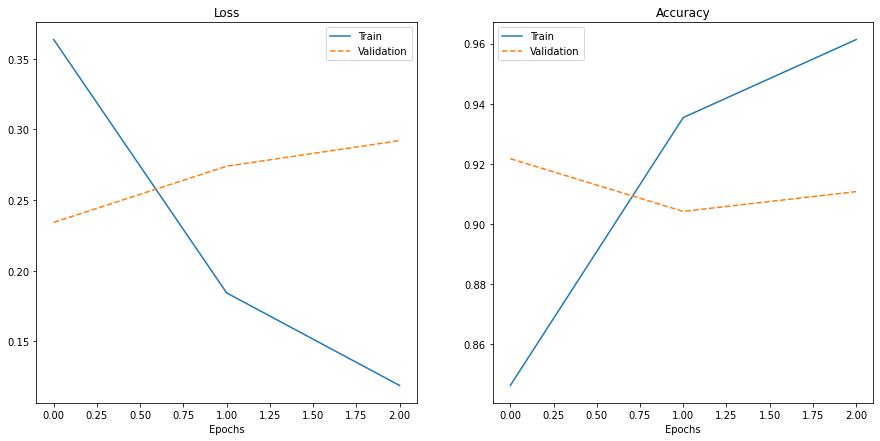

In [126]:
# grab history -- hypertuned model
history = hist.history

# set plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# plot loss
ax1.plot(history['loss'])
ax1.plot(history['val_loss'], linestyle='--')
ax1.legend(['Train', 'Validation'], loc=0)
ax1.set_xlabel('Epochs')
ax1.set_title('Loss')

# plot accuracy
ax2.plot(history['accuracy'])
ax2.plot(history['val_accuracy'], linestyle='--')
ax2.legend(['Train', 'Validation'], loc=0)
ax2.set_xlabel('Epochs')
ax2.set_title('Accuracy')

plt.show()

In [127]:
# tokenize and prepare datasets for evaluation

truncate = True
pad = True

# tokenize data
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

train_tokens = tokenizer(list(X_train.ravel().astype('U')),
                         max_length=best_hps.values['max_length'],
                         truncation=truncate,
                         padding=pad)

valid_tokens = tokenizer(list(X_valid.ravel().astype('U')),
                         max_length=best_hps.values['max_length'],
                         truncation=truncate,
                         padding=pad)

train_valid_tokens = tokenizer(list(np.concatenate((X_train, X_valid)).astype('U')),
                                    max_length=best_hps.values['max_length'],
                                    truncation=truncate,
                                    padding=pad)

test_tokens = tokenizer(list(X_test.ravel().astype('U')),
                         max_length=best_hps.values['max_length'],
                         truncation=truncate,
                         padding=pad)

# convert to tensors
train_tensor = tf.data.Dataset.from_tensor_slices((dict(train_tokens), y_train))
valid_tensor = tf.data.Dataset.from_tensor_slices((dict(valid_tokens), y_valid))
train_valid_tensor = tf.data.Dataset.from_tensor_slices((dict(train_valid_tokens), np.concatenate((y_train, y_valid))))
test_tensor = tf.data.Dataset.from_tensor_slices((dict(test_tokens), y_test))

# batch
train_tensor = train_tensor.batch(best_hps.values['batch_size'])
valid_tensor = valid_tensor.batch(best_hps.values['batch_size'])
train_valid_tensor = train_valid_tensor.batch(best_hps.values['batch_size'])
test_tensor = test_tensor.batch(best_hps.values['batch_size'])

In [370]:
# get predictions using current hypertuned model, with weights from best epoch

# probs
train_probs = tf.keras.activations.softmax(tf.convert_to_tensor(model.predict(train_tensor).logits)).numpy()
valid_probs = tf.keras.activations.softmax(tf.convert_to_tensor(model.predict(valid_tensor).logits)).numpy()

# preds
train_preds = (train_probs[:,1] >= 0.5).astype(bool)
valid_preds = (valid_probs[:,1] >= 0.5).astype(bool)

29/29 [==============================] - 82s 3s/step


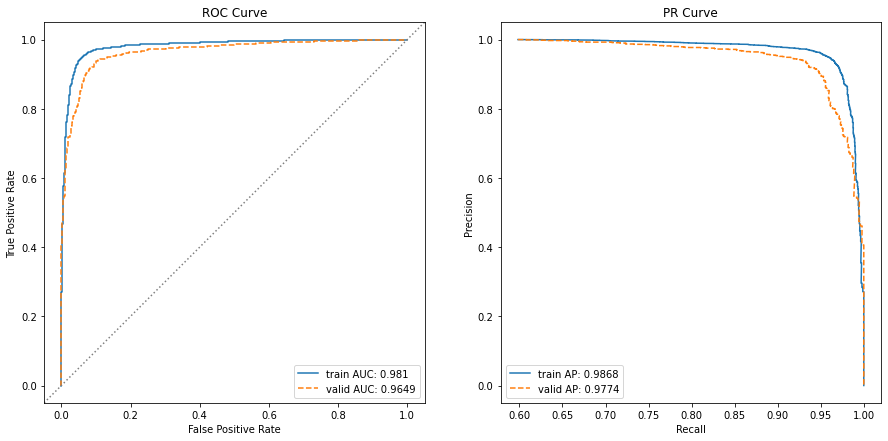

In [371]:
# auc -- train vs valid hyper tuned
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

fpr_train, tpr_train, _ = roc_curve(y_train, train_probs[:,1])
fpr_valid, tpr_valid, _ = roc_curve(y_valid, valid_probs[:,1])

# pr
prec_train, recall_train, _ = precision_recall_curve(y_train, train_probs[:,1])
prec_valid, recall_valid, _ = precision_recall_curve(y_valid, valid_probs[:,1])

ax1.plot(fpr_train, tpr_train, label=f'train AUC: {round(roc_auc_score(y_train, train_probs[:,1]),4)}')
ax1.plot(fpr_valid, tpr_valid, label=f'valid AUC: {round(roc_auc_score(y_valid, valid_probs[:,1]),4)}', 
         linestyle='--')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, color='gray', linestyle=':')

ax2.plot(prec_train, recall_train, label=f'train AP: {round(average_precision_score(y_train, train_probs[:,1]),4)}')
ax2.plot(prec_valid, recall_valid, label=f'valid AP: {round(average_precision_score(y_valid, valid_probs[:,1]),4)}', 
         linestyle='--')

ax1.legend(loc=0)
ax2.legend(loc=0)

ax1.set_title('ROC Curve')
ax2.set_title('PR Curve')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

plt.show()

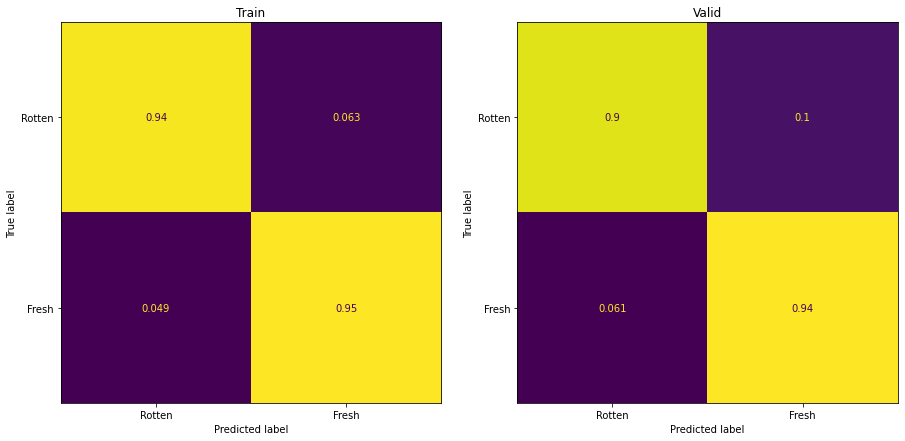

In [372]:
# confusion matrix -- train vs valid hypertuned
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

cm_train = confusion_matrix(y_train, train_preds,
                            normalize='true')

cm_valid = confusion_matrix(y_valid, valid_preds,
                           normalize='true')

ConfusionMatrixDisplay(confusion_matrix=cm_train,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax1, colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=cm_valid,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax2, colorbar=False)

ax1.set_title('Train')
ax2.set_title('Valid')

plt.show()

In [373]:
# looks like we have an issue with false positives in our validation set, let's look at the first 5 examples

[X_valid.to_numpy()[i] for i in range(valid_preds.size) if valid_preds[i] != y_valid.to_numpy()[i]][:5]

["Glen or Glenda? remains an interesting artifact from one of Hollywood's more colorful careers -- albeit not one that holds up particularly well as a movie.",
 "iBoy's original premise and Maisie Williams' strong performance aren't enough to overwrite a clichéd narrative, too-serious tone, and overall glitchy execution.",
 'Our House sits on a solid foundation of genuine pathos, even if the storytelling structure tends to be frustratingly rickety in spots.',
 'Everybody Knows is somewhat less than the sum of its parts despite the efforts of an outstanding cast - and a disappointing step back for writer-director Asghar Farhadi.',
 "As excessive and ketchup laden as predecessors Suspiria and Inferno, Dario Argento's Mother of Tears completes the trilogy with the same baroque grandeur and soggy 1970s sensibilities."]

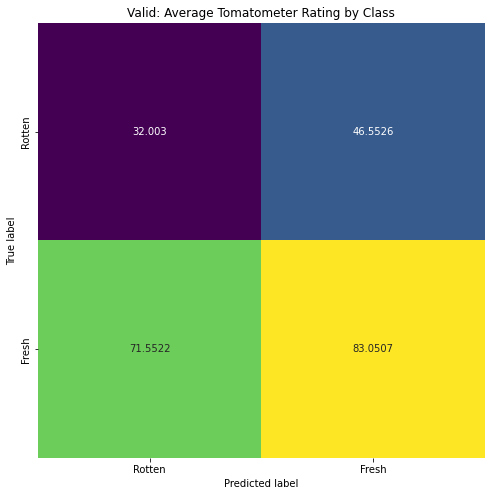

In [374]:
# let's average the ratings across our groups for subgroup analysis on this hypertuned model

# set plot
fig, ax = plt.subplots(figsize=(8, 8))

tp_avg = np.mean(
    [movies.loc[X_valid.index[i], 'tomatometer_rating'] for i in range(valid_preds.size) 
     if valid_preds[i] and y_valid.to_numpy()[i]]
)

fp_avg = np.mean(
    [movies.loc[X_valid.index[i], 'tomatometer_rating'] for i in range(valid_preds.size) 
     if valid_preds[i] and (not y_valid.to_numpy()[i])]
)

tn_avg = np.mean(
    [movies.loc[X_valid.index[i], 'tomatometer_rating'] for i in range(valid_preds.size) 
     if (not valid_preds[i]) and (not y_valid.to_numpy()[i])]
)

fn_avg = np.mean(
    [movies.loc[X_valid.index[i], 'tomatometer_rating'] for i in range(valid_preds.size) 
     if (not valid_preds[i]) and y_valid.to_numpy()[i]]
)

sns.heatmap(np.array([[tn_avg, fp_avg], 
                      [fn_avg, tp_avg]]), 
            annot=True, 
            fmt='g',
            cbar=False,
            cmap='viridis',
            ax=ax)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label'); 
ax.set_title('Valid: Average Tomatometer Rating by Class')
ax.xaxis.set_ticklabels(['Rotten', 'Fresh'])
ax.yaxis.set_ticklabels(['Rotten', 'Fresh'])

plt.show()

In [375]:
# for fun, let's evaluate on non-finetuned for comparison
orig_model = TFDistilBertForSequenceClassification.from_pretrained(model_name,
                                                                   num_labels=2)

orig_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.values['learning_rate']),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

orig_train_evaluation = orig_model.evaluate(train_tensor, batch_size=best_hps.values['batch_size'], verbose=1)
orig_valid_evaluation = orig_model.evaluate(valid_tensor, batch_size=best_hps.values['batch_size'], verbose=1)

orig_train_accuracy = round(orig_train_evaluation[1],4)
orig_valid_accuracy = round(orig_valid_evaluation[1],4)
orig_train_loss = round(orig_train_evaluation[0],4)
orig_valid_loss = round(orig_valid_evaluation[0],4)

model_results = model_results.append({
    'Run ID': '01', 
    'Algorithm': 'DistilBERT', 
    'Description': 'baseline w/o finetuning', 
    'Train Loss': orig_train_loss,
    'Valid Loss': orig_valid_loss,
    'Train Accuracy': orig_train_accuracy, 
    'Valid Accuracy': orig_valid_accuracy
}, ignore_index=True)

29/29 [==============================] - 80s 3s/step - loss: 0.6878 - accuracy: 0.6015


In [376]:
# evaluate train vs valid on hypertuned model version
hypbert_train_accuracy = round(accuracy_score(train_preds, y_train),4)
hypbert_valid_accuracy = round(accuracy_score(valid_preds, y_valid),4)
hypbert_train_loss = round(tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_train, train_probs).numpy(),4)
hypbert_valid_loss = round(tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_valid, valid_probs).numpy(),4)

model_results = model_results.append({
    'Run ID': '02', 
    'Algorithm': 'DistilBERT', 
    'Description': 'Hyperparameter Tuned, early stopping', 
    'Train Loss': hypbert_train_loss, 
    'Valid Loss': hypbert_valid_loss, 
    'Train Accuracy': hypbert_train_accuracy, 
    'Valid Accuracy': hypbert_valid_accuracy
}, ignore_index=True)

print('train accuracy: %s' % hypbert_train_accuracy)
print('valid accuracy: %s' % hypbert_valid_accuracy)

train accuracy: 0.9453
valid accuracy: 0.9217


In [377]:
# get best epoch from training, where weights were reverted to upon early stopping
val_acc_per_epoch = hist.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


In [83]:
# Re-instantiate the hypermodel and train it on the combination of validation and test
# with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hps)

final_model_hist = hypermodel.fit(train_valid_tensor, # combination of train and valid
                                  epochs=best_epoch, # pull from refit above
                                  verbose=1)

115/115 [==============================] - 1744s 15s/step - loss: 0.3377 - accuracy: 0.8577


In [378]:
# predict -- final model

# probs
train_probs = tf.keras.activations.softmax(tf.convert_to_tensor(hypermodel.predict(train_tensor).logits)).numpy()
valid_probs = tf.keras.activations.softmax(tf.convert_to_tensor(hypermodel.predict(valid_tensor).logits)).numpy()
train_valid_probs = tf.keras.activations.softmax(tf.convert_to_tensor(hypermodel.predict(train_valid_tensor).logits)).numpy()
test_probs = tf.keras.activations.softmax(tf.convert_to_tensor(hypermodel.predict(test_tensor).logits)).numpy()

# preds
train_preds = (train_probs[:,1] >= 0.5).astype(bool)
valid_preds = (valid_probs[:,1] >= 0.5).astype(bool)
train_valid_preds = (train_valid_probs[:,1] >= 0.5).astype(bool)
test_preds = (test_probs[:,1] >= 0.5).astype(bool)

29/29 [==============================] - 118s 4s/step


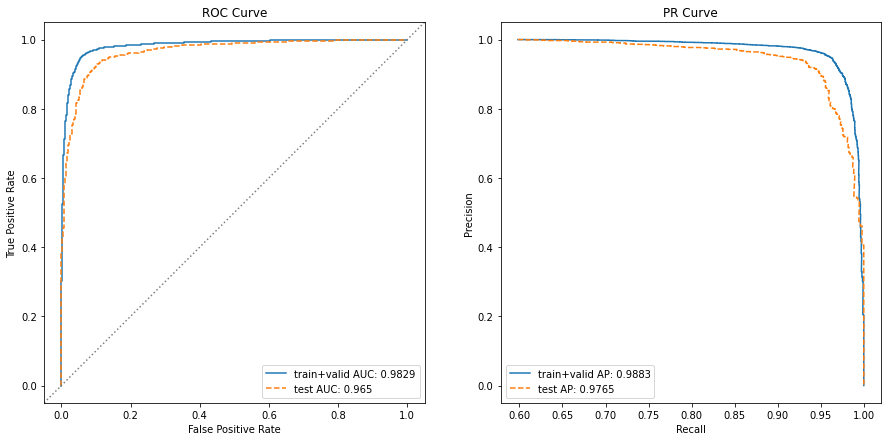

In [379]:
# auc on final model
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

fpr_train_valid, tpr_train_valid, _ = roc_curve(np.concatenate((y_train, y_valid)), train_valid_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test, test_probs[:,1])

# pr
prec_train, recall_train, _ = precision_recall_curve(np.concatenate((y_train, y_valid)), train_valid_probs[:,1])
prec_test, recall_test, _ = precision_recall_curve(y_test, test_probs[:,1])

ax1.plot(fpr_train_valid, tpr_train_valid, 
         label=f'train+valid AUC: {round(roc_auc_score(np.concatenate((y_train, y_valid)),train_valid_probs[:,1]),4)}')
ax1.plot(fpr_test, tpr_test, label=f'test AUC: {round(roc_auc_score(y_test, test_probs[:,1]),4)}', 
         linestyle='--')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, color='gray', linestyle=':')

ax2.plot(prec_train, recall_train, 
         label=f'train+valid AP: {round(average_precision_score(np.concatenate((y_train, y_valid)),train_valid_probs[:,1]),4)}')
ax2.plot(prec_valid, recall_valid, label=f'test AP: {round(average_precision_score(y_test, test_probs[:,1]),4)}', 
         linestyle='--')

ax1.legend(loc=0)
ax2.legend(loc=0)

ax1.set_title('ROC Curve')
ax2.set_title('PR Curve')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

plt.show()

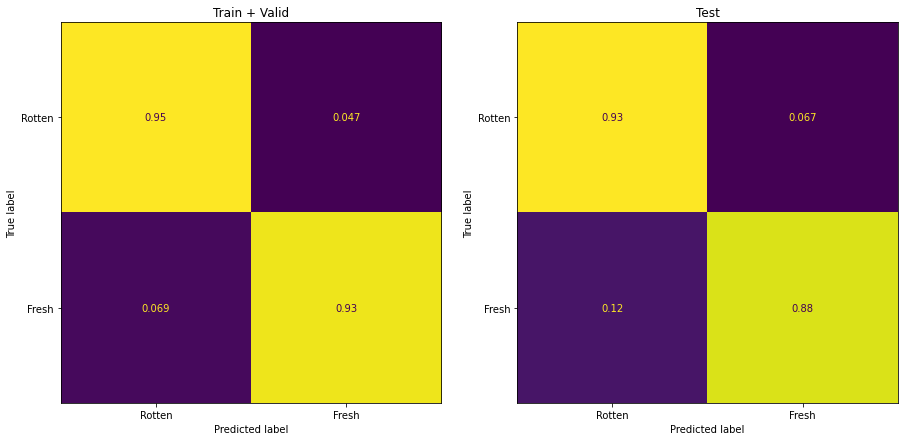

In [380]:
# confusion matrix -- final model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

cm_train_valid = confusion_matrix(np.concatenate((y_train, y_valid)), train_valid_preds,
                                  normalize='true')

cm_test = confusion_matrix(y_test, test_preds,
                           normalize='true')

ConfusionMatrixDisplay(confusion_matrix=cm_train_valid,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax1, colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=cm_test,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax2, colorbar=False)

ax1.set_title('Train + Valid')
ax2.set_title('Test')

plt.show()

In [381]:
# looks like we have an issue with false negatives in our test set, let's look at the first 5 examples

[X_test.to_numpy()[i] for i in range(test_preds.size) if test_preds[i] != y_test.to_numpy()[i]][:5]

["Peter Jackson's return to Middle-earth is an earnest, visually resplendent trip, but the film's deliberate pace robs the material of some of its majesty.",
 'Conceptually audacious but only intermittently successful in execution, Escape From Tomorrow is nonetheless visually inventive and darkly surreal.',
 'The Last Full Measure struggles to capture the incidents that inspired it, but ultimately prevails thanks to strong performances in service of a remarkable true story.',
 "Director Gulager makes the most of what he's given; the resulting Feast offers up some surprisingly tasty -- if far from nourishing -- morsels.",
 'The story may be a bit too melodramatic, but great performances abound in Songcatcher. The real reason to see the movie, however, is the hypnotic music.']

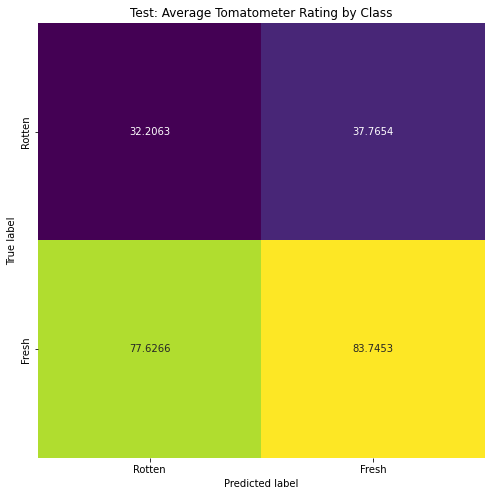

In [548]:
# let's average the ratings across our groups for subgroup analysis

# set plot
fig, ax = plt.subplots(figsize=(8, 8))

tp_avg = np.mean(
    [movies.loc[X_test.index[i], 'tomatometer_rating'] for i in range(test_preds.size) 
     if test_preds[i] and y_test.to_numpy()[i]]
)

fp_avg = np.mean(
    [movies.loc[X_test.index[i], 'tomatometer_rating'] for i in range(test_preds.size) 
     if test_preds[i] and (not y_test.to_numpy()[i])]
)

tn_avg = np.mean(
    [movies.loc[X_test.index[i], 'tomatometer_rating'] for i in range(test_preds.size) 
     if (not test_preds[i]) and (not y_test.to_numpy()[i])]
)

fn_avg = np.mean(
    [movies.loc[X_test.index[i], 'tomatometer_rating'] for i in range(test_preds.size) 
     if (not test_preds[i]) and y_test.to_numpy()[i]]
)

sns.heatmap(np.array([[tn_avg, fp_avg], 
                      [fn_avg, tp_avg]]), 
            annot=True, 
            fmt='g',
            cbar=False,
            cmap='viridis',
            ax=ax)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label'); 
ax.set_title('Test: Average Tomatometer Rating by Class')
ax.xaxis.set_ticklabels(['Rotten', 'Fresh'])
ax.yaxis.set_ticklabels(['Rotten', 'Fresh'])

plt.show()

In [383]:
# accuracy on final model
finalbert_train_valid_accuracy = round(accuracy_score(train_valid_preds, np.concatenate((y_train, y_valid))),4)
finalbert_test_accuracy = round(accuracy_score(test_preds, y_test), 4)

finalbert_train_valid_loss = round(
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(np.concatenate((y_train, y_valid)),
                                                                    train_valid_probs).numpy(),4)
finalbert_test_loss = round(tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_test, test_probs).numpy(),4)

final_model_results = pd.DataFrame({
    'Run ID': ['03'], 
    'Algorithm': ['DistilBERT'],
    'Description': ['hypertuned, retrained on train+valid'], 
    'Train+Valid Loss': [finalbert_train_valid_loss], 
    'Test Loss': [finalbert_test_loss], 
    'Train+Valid Accuracy': [finalbert_train_valid_accuracy], 
    'Test Accuracy': [finalbert_test_accuracy]
})

print('train_valid accuracy: %s' % finalbert_train_valid_accuracy)
print('test accuracy: %s' % finalbert_test_accuracy)

train_valid accuracy: 0.9399
test accuracy: 0.9037


In [290]:
# finally save the final model for future reference

hypermodel.save_pretrained('../models/critics_consensus_bert_v7/distilbert_final_hypertuned_retrained_incl_valid')

In [385]:
# display intermediary results and save

model_results.to_csv('../results/model_results_summary.csv',
                     index=False)
model_results

,Run ID,Algorithm,Description,Train Loss,Valid Loss,Train Accuracy,Valid Accuracy
0,00,Logistic regression,L2 regularization,0.4195,0.4593,0.8197,0.7947
1,01,DistilBERT,baseline w/o finetuning,0.6880,0.6878,0.6011,0.6015
2,02,DistilBERT,"Hyperparameter Tuned, early stopping",0.1741,0.2342,0.9453,0.9217


In [387]:
# display final results and save

final_model_results.to_csv('../results/final_model_results_summary.csv',
                           index=False)
final_model_results

,Run ID,Algorithm,Description,Train+Valid Loss,Test Loss,Train+Valid Accuracy,Test Accuracy
0,03,DistilBERT,"hypertuned, retrained on train+valid",0.1832,0.262,0.9399,0.9037


In [572]:
# Fair -- subgroup analysis

mlb = MultiLabelBinarizer()
genres_vector = mlb.fit_transform(movies.loc[X_test.index, 'genres'] \
                                        .apply(lambda x: x if not isinstance(x, float) else '').str.split(', '))

genres_subgroup = pd.DataFrame(columns=['genre', 'n', 'loss', 'accuracy']) 
for i,genre in enumerate(mlb.classes_):
    mask = np.where(genres_vector[:,i])[0]
    genres_subgroup = genres_subgroup.append(
        {'genre': genre,
         'n': len(mask),
         'loss': round(tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_test.to_numpy()[mask], 
                                                                                        test_probs[mask]).numpy(),4),
         'accuracy': round(accuracy_score(test_preds[mask], y_test.to_numpy()[mask]),4)
        }, ignore_index=True
    )

genres_subgroup.to_csv('../results/genres_subgroup_analysis_fairness_test_set.csv', index=False)
genres_subgroup


,genre,n,loss,accuracy
0,Action & Adventure,408,0.4938,0.7647
1,Animation,85,0.4592,0.7647
2,Anime & Manga,3,0.2344,1.0000
3,Art House & International,227,0.4869,0.7665
4,Classics,94,0.4623,0.7872
5,Comedy,607,0.5063,0.7496
6,Cult Movies,10,0.5848,0.6000
7,Documentary,168,0.3434,0.8690
8,Drama,999,0.4691,0.7908
9,Faith & Spirituality,9,0.3902,0.8889


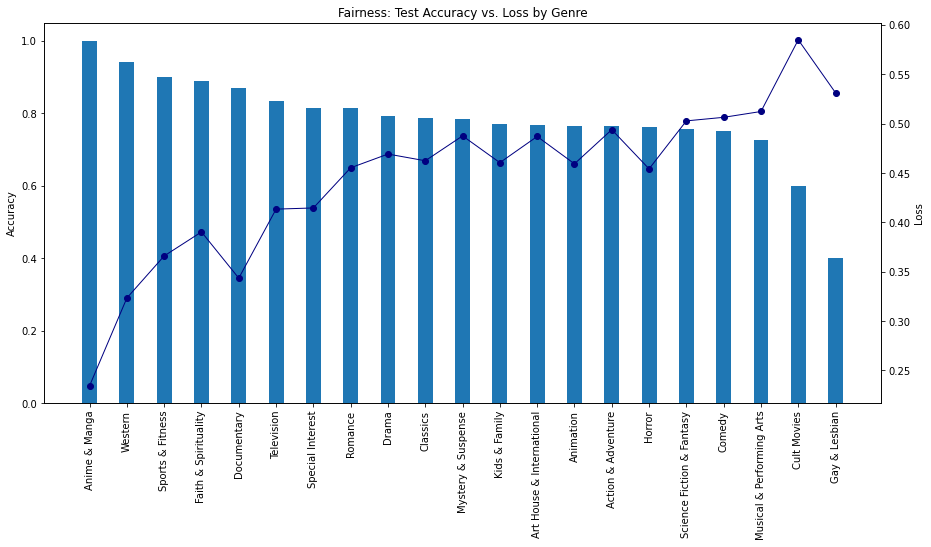

In [714]:
# visualize fairness

# set plots
fig, ax = plt.subplots(figsize=(15, 7))
plt.xticks(rotation = 90)
ax2 = ax.twinx()

# plot
genres_subgroup = genres_subgroup.sort_values('accuracy', ascending=False)
ax.bar(x=genres_subgroup['genre'], height=genres_subgroup['accuracy'], width=0.4)
ax2.plot(ax.get_xticks(), genres_subgroup['loss'], marker='o', c='navy', linewidth=1)

ax.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

plt.title('Fairness: Test Accuracy vs. Loss by Genre')
plt.show()

In [789]:
# shap on test -- first two vals

pred_pipe = trans_pipe('text-classification', model=hypermodel, tokenizer=tokenizer, device=0, top_k=2)
explainer = shap.Explainer(pred_pipe)

shap_values = explainer(X_test[X_test.index[:5]]) # filter to first two vals

  0%|          | 0/110 [00:00<?, ?it/s]

Partition explainer:  20%|██████████████▏                                                        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|█████████████████████████████████████▊                         | 3/5 [02:17<01:48, 54.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|██████████████████████████████████████████████████▍            | 4/5 [04:06<01:17, 77.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|███████████████████████████████████████████████████████████████| 5/5 [05:57<00:00, 89.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 6it [07:46, 93.23s/it]                                                                            


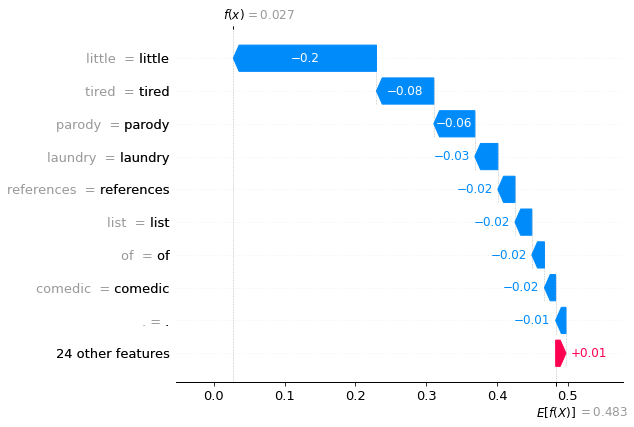

In [797]:
# display shap waterfall for given observation
shap.plots.waterfall(shap_values[1,:,1])

In [788]:
# show explained review
X_test[X_test.index[1]]

'Loaded Weapon 1 hits all the routine targets with soft squibs, yielding a tired parody that cycles through its laundry list of references with little comedic verve.'

In [802]:
# show prediction and ground truth
print('prediction:', test_preds[1])
print('ground truth:', y_test[y_test.index[1]])

prediction: False
ground truth: 0
